# Classification

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (accuracy_score)

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier

from sklearn.svm import SVC
import xgboost as xgb
from sklearn.feature_selection import SelectKBest, f_classif

from autogluon.tabular import TabularPredictor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

pd.set_option('display.max_rows', 500)

c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import datasets
df_radiomics = pd.read_excel('data/complete_df.xlsx')
df_radiomics.head()

,classe_name,patient_num,Gender,Age_at_disease,Alpha_foetoprotein,Local_relapse,Distant_relapse,Death,Date_of_lost_of_FU,survival_time,...,original_glszm_SmallAreaHighGrayLevelEmphasis_TARD,original_glszm_SmallAreaLowGrayLevelEmphasis_TARD,original_glszm_ZoneEntropy_TARD,original_glszm_ZonePercentage_TARD,original_glszm_ZoneVariance_TARD,original_ngtdm_Busyness_TARD,original_ngtdm_Coarseness_TARD,original_ngtdm_Complexity_TARD,original_ngtdm_Contrast_TARD,original_ngtdm_Strength_TARD
0,0,10,1,62.0,NaN,0,0,1,NaT,133.0,...,33.413109,0.009836,6.090384,0.166814,87.980503,1.770498,0.003704,39.277987,0.015188,0.332041
1,0,11,0,57.0,6.1,0,0,0,2017-06-08,NaN,...,712.327011,0.007341,6.313498,0.841126,0.268177,0.163645,0.004702,11442.875990,0.449753,9.512513
2,0,12,1,58.0,1.4,0,1,1,NaT,1812.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,13,1,65.0,0.0,0,1,1,NaT,2089.0,...,11.427517,0.035033,5.902304,0.066641,2534.900063,29.486908,0.000621,13.679928,0.009523,0.023968
4,0,14,1,64.0,0.0,0,0,1,NaT,11.0,...,2.908817,0.138365,4.091810,0.059633,762.292899,7.167425,0.011379,1.508313,0.013621,0.061704


In [3]:
data_n = df_radiomics.select_dtypes(include=['float64','int64','bool'])
data_del = df_radiomics.select_dtypes(include=['datetime64','object'])
#data = data_n.T.drop_duplicates().T
data = data_n.dropna(axis=1, how='all')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Columns: 442 entries, classe_name to original_ngtdm_Strength_TARD
dtypes: bool(2), float64(434), int64(6)
memory usage: 505.7 KB


### Train Test Split

In [4]:
X_init = data.drop(columns=['dead_after_one_year', 'dead_after_six_year','patient_num','survival_time','Death','distant_relapse_time','local_relapse_time','Distant_relapse','Local_relapse'])
imp = IterativeImputer(max_iter=10, random_state=42)
df_imputed = imp.fit_transform(X_init)
original_columns = X_init.columns.tolist()
X = pd.DataFrame(df_imputed, columns=range(1, len(X_init.columns) + 1))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=range(1, len(X_init.columns) + 1),index=X_init.index)
y = data['dead_after_one_year']

In [5]:
X_original_col = pd.DataFrame(X_scaled, columns=original_columns,index=X_init.index)

In [6]:
X_original_col.info()
X_original_col.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Columns: 433 entries, classe_name to original_ngtdm_Strength_TARD
dtypes: float64(433)
memory usage: 497.4 KB


,classe_name,Gender,Age_at_disease,Alpha_foetoprotein,censorship_time,original_firstorder_10Percentile_ART,original_firstorder_90Percentile_ART,original_firstorder_Energy_ART,original_firstorder_Entropy_ART,original_firstorder_InterquartileRange_ART,...,original_glszm_SmallAreaHighGrayLevelEmphasis_TARD,original_glszm_SmallAreaLowGrayLevelEmphasis_TARD,original_glszm_ZoneEntropy_TARD,original_glszm_ZonePercentage_TARD,original_glszm_ZoneVariance_TARD,original_ngtdm_Busyness_TARD,original_ngtdm_Coarseness_TARD,original_ngtdm_Complexity_TARD,original_ngtdm_Contrast_TARD,original_ngtdm_Strength_TARD
0,-1.73369,0.510831,-0.014690,-0.155957,-0.036886,0.057779,0.105982,-0.183445,0.623743,0.335063,...,-0.153187,0.065268,0.586421,0.047520,-0.349568,-0.571272,-0.027756,-0.170140,-0.031927,-0.164604
1,-1.73369,-1.697761,-0.432703,-0.191678,-0.726943,0.257586,1.489586,-0.139128,2.318971,4.114009,...,1.339157,0.065234,0.824223,0.348132,-0.390495,-0.641215,-0.027665,3.485733,1.156538,2.649545
2,-1.73369,0.510831,-0.349101,-0.191851,0.026933,-0.076511,-0.206445,-0.175037,-0.307842,-0.409136,...,0.047874,-2.447297,0.742399,-2.604361,-0.027290,-0.124276,1.401036,0.002945,-0.783581,0.089089
3,-1.73369,0.510831,0.236117,-0.191903,-0.103042,-0.528212,-0.566129,-0.201586,-0.759879,-0.604336,...,-0.201515,0.065612,0.385960,0.002862,0.792185,0.635172,-0.028035,-0.178347,-0.047419,-0.259040
4,-1.73369,0.510831,0.152515,-0.191903,-0.048128,-0.353229,-0.421730,-0.212417,-0.512066,-0.494536,...,-0.220240,0.067021,-1.543719,-0.000262,-0.034928,-0.336354,-0.027059,-0.182249,-0.036213,-0.247472


### Feature selection

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [8]:
selector = SelectKBest(score_func=f_classif, k=40)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
selected_columns = X_original_col.columns[selector.get_support()]
X_train_selected_df = pd.DataFrame(X_train_selected, columns=selected_columns,index=X_train.index)
X_test_selected_df = pd.DataFrame(X_test_selected, columns=selected_columns,index=X_test.index)

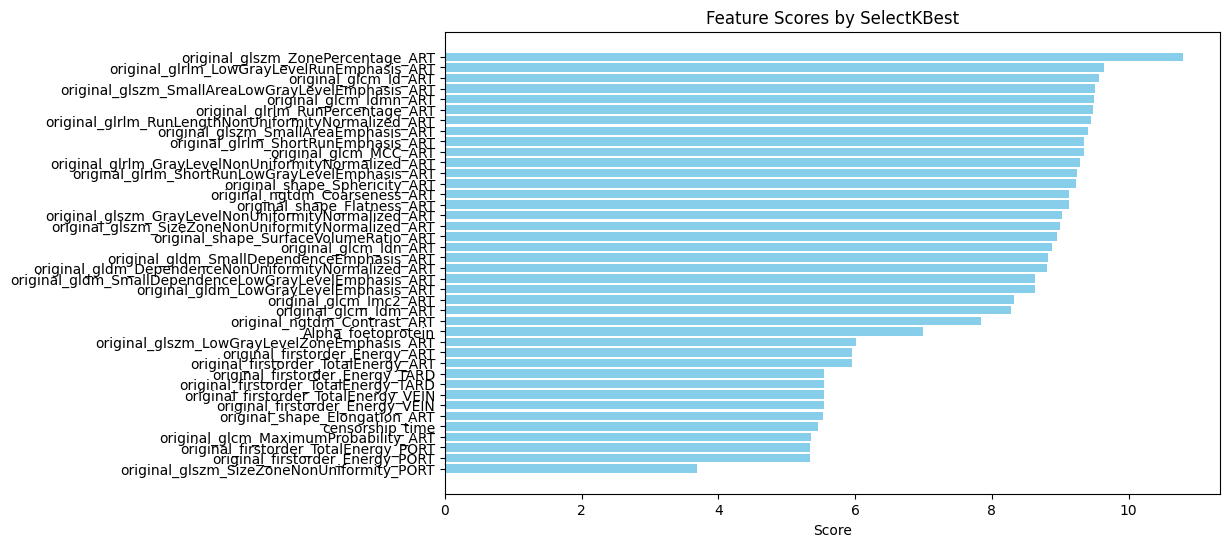

In [9]:
scores = selector.scores_[selector.get_support()]
feature_scores = pd.DataFrame({'Feature': selected_columns, 'Score': scores})
feature_scores = feature_scores.sort_values(by='Score', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feature_scores['Feature'], feature_scores['Score'], color='skyblue')
plt.xlabel('Score')
plt.title('Feature Scores by SelectKBest')
plt.gca().invert_yaxis()
plt.show()

### Baseline Model

In [10]:
# Baseline
y.value_counts()

dead_after_one_year
False    130
True      17
Name: count, dtype: int64

### Model Preparation

In [11]:
# Instiantiate models
models = {'lr': LogisticRegression(max_iter=5_000, random_state=42, solver='saga'),
          'rf': RandomForestClassifier(random_state=42),
          'gb': GradientBoostingClassifier(random_state=42),
          'dt': DecisionTreeClassifier(random_state=42),
          'et': ExtraTreesClassifier(random_state=42),
          'ada': AdaBoostClassifier(random_state=42),
          'svc': SVC(random_state=42, probability=True),
          'xgb': xgb.XGBClassifier(random_state=42)
        }

In [12]:
# Instantiate lists to store results
init_list = []
gs_list = []

# Function to run model -- input scaler and model
def run_model(mod, mod_params={}, grid_search=False, mission = 'After one year'):
    
    # Initial dictionary to hold model results
    results = {}
    
    pipe = Pipeline([
            ('ss', StandardScaler()),
            (mod, models[mod])
            ])
    
    if grid_search:
        # Instantiate list to store gridsearch results
        gs = GridSearchCV(pipe, param_grid=mod_params, cv=3, verbose=1, scoring='roc_auc', n_jobs=-1)
        gs.fit(X_train_selected_df, y_train)
        pipe = gs
        
    else:
        pipe.fit(X_train_selected_df, y_train)
    
    # Retrieve metrics
    predictions = pipe.predict(X_test_selected_df)
    y_train_pred = pipe.predict(X_train_selected_df)
    
    results['model'] = mod
    results['mission'] = mission
    results['train_accuracy'] = accuracy_score(y_train,y_train_pred)
    results['test_accuracy'] = accuracy_score(y_test,predictions)
    #results['precision'] = precision_score(y_test, predictions)
    #results['recall'] = recall_score(y_test, predictions)
    #results['f_score'] = f1_score(y_test, predictions)
    
    if grid_search:
        gs_list.append(results)
        print('### BEST PARAMS ###')
        display(pipe.best_params_)
        
    else:
        init_list.append(results)
    
    print('### METRICS ###')
    display(results)
    
    print(f"train accuracy: {results['train_accuracy']}")
    print(f"test accuracy: {results['test_accuracy']}")
    
    return pipe

## Model Benchmarks 
Here, we're simply running our models with no class adjustments and no hyper-parameter tuning. It's worth noting that <b>without feature engineering, our models performed substantially worse.</b> In iterations without feature engineering our Logistic Regression and AdaBoosting classifiers completely failed to identify any true positives.

In [13]:
lr = run_model('lr',mission='After one year')

### METRICS ###


{'model': 'lr',
 'mission': 'After one year',
 'train_accuracy': 0.9117647058823529,
 'test_accuracy': 0.8666666666666667}

train accuracy: 0.9117647058823529
test accuracy: 0.8666666666666667


In [14]:
dt = run_model('dt',mission='After one year')

### METRICS ###


{'model': 'dt',
 'mission': 'After one year',
 'train_accuracy': 1.0,
 'test_accuracy': 0.7777777777777778}

train accuracy: 1.0
test accuracy: 0.7777777777777778


In [15]:
rf = run_model('rf',mission='After one year')

### METRICS ###


{'model': 'rf',
 'mission': 'After one year',
 'train_accuracy': 1.0,
 'test_accuracy': 0.8888888888888888}

train accuracy: 1.0
test accuracy: 0.8888888888888888


In [16]:
gb = run_model('gb',mission='After one year')

### METRICS ###


{'model': 'gb',
 'mission': 'After one year',
 'train_accuracy': 1.0,
 'test_accuracy': 0.8222222222222222}

train accuracy: 1.0
test accuracy: 0.8222222222222222


In [17]:
et = run_model('et',mission='After one year')

### METRICS ###


{'model': 'et',
 'mission': 'After one year',
 'train_accuracy': 1.0,
 'test_accuracy': 0.8444444444444444}

train accuracy: 1.0
test accuracy: 0.8444444444444444


In [18]:
svc = run_model('svc',mission='After one year')

### METRICS ###


{'model': 'svc',
 'mission': 'After one year',
 'train_accuracy': 0.9019607843137255,
 'test_accuracy': 0.8888888888888888}

train accuracy: 0.9019607843137255
test accuracy: 0.8888888888888888


In [19]:
ada = run_model('ada',mission='After one year')

c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


### METRICS ###


{'model': 'ada',
 'mission': 'After one year',
 'train_accuracy': 1.0,
 'test_accuracy': 0.8444444444444444}

train accuracy: 1.0
test accuracy: 0.8444444444444444


In [20]:
xg = run_model('xgb',mission='After one year')

### METRICS ###


{'model': 'xgb',
 'mission': 'After one year',
 'train_accuracy': 1.0,
 'test_accuracy': 0.8888888888888888}

train accuracy: 1.0
test accuracy: 0.8888888888888888


In [21]:
# Results of our initial modelling
pd.DataFrame(init_list).sort_values(by='test_accuracy', ascending=False).reset_index(drop=True)

,model,mission,train_accuracy,test_accuracy
0,rf,After one year,1.000000,0.888889
1,svc,After one year,0.901961,0.888889
2,xgb,After one year,1.000000,0.888889
3,lr,After one year,0.911765,0.866667
4,et,After one year,1.000000,0.844444
5,ada,After one year,1.000000,0.844444
6,gb,After one year,1.000000,0.822222
7,dt,After one year,1.000000,0.777778


#### Six years

In [22]:
y = data['dead_after_six_year']

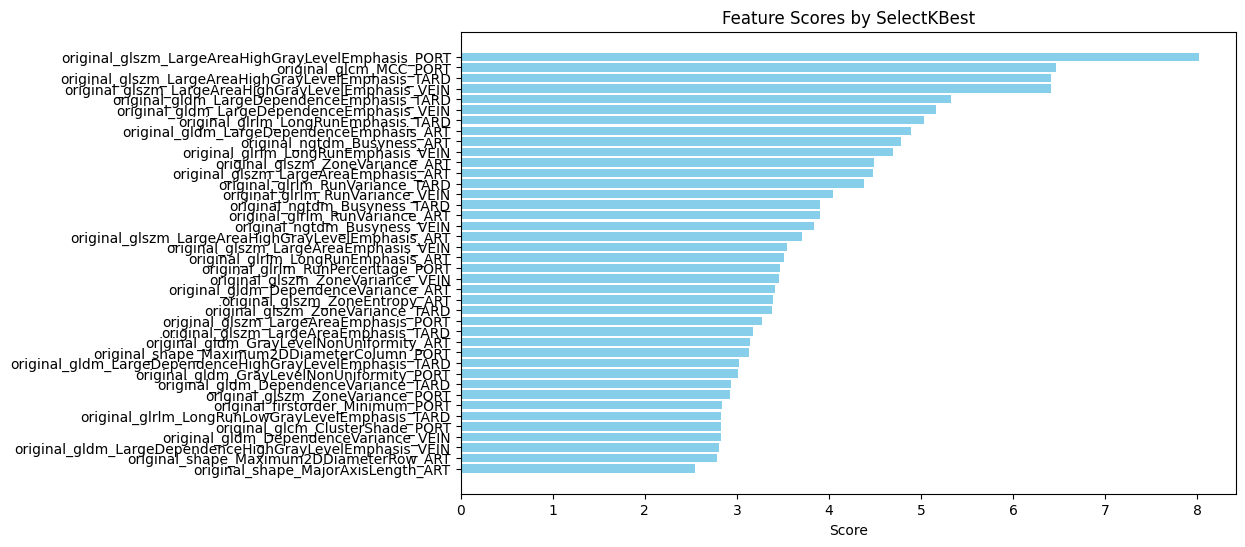

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
X_train_label, X_test_label, y_train_label, y_test_label = train_test_split(X_original_col, y, test_size=0.3, stratify=y, random_state=42)
selector = SelectKBest(score_func=f_classif, k=40)
X_train_selected = selector.fit_transform(X_train_label, y_train_label)
X_test_selected = selector.transform(X_test_label)
selected_columns = X_original_col.columns[selector.get_support()]
X_train_selected_df = pd.DataFrame(X_train_selected, columns=selected_columns,index=X_train.index)
X_test_selected_df = pd.DataFrame(X_test_selected, columns=selected_columns,index=X_test.index)
scores = selector.scores_[selector.get_support()]
feature_scores = pd.DataFrame({'Feature': selected_columns, 'Score': scores})
feature_scores = feature_scores.sort_values(by='Score', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feature_scores['Feature'], feature_scores['Score'], color='skyblue')
plt.xlabel('Score')
plt.title('Feature Scores by SelectKBest')
plt.gca().invert_yaxis()
plt.show()

In [24]:
y.value_counts()

dead_after_six_year
False    101
True      46
Name: count, dtype: int64

In [25]:
lr = run_model('lr',mission='After six years')
dt = run_model('dt',mission='After six years')
rf = run_model('rf',mission='After six years')
gb = run_model('gb',mission='After six years')
et = run_model('et',mission='After six years')
svc = run_model('svc',mission='After six years')
ada = run_model('ada',mission='After six years')
xg = run_model('xgb',mission='After six years')

### METRICS ###


{'model': 'lr',
 'mission': 'After six years',
 'train_accuracy': 0.803921568627451,
 'test_accuracy': 0.6444444444444445}

train accuracy: 0.803921568627451
test accuracy: 0.6444444444444445
### METRICS ###


{'model': 'dt',
 'mission': 'After six years',
 'train_accuracy': 1.0,
 'test_accuracy': 0.5111111111111111}

train accuracy: 1.0
test accuracy: 0.5111111111111111
### METRICS ###


{'model': 'rf',
 'mission': 'After six years',
 'train_accuracy': 1.0,
 'test_accuracy': 0.6444444444444445}

train accuracy: 1.0
test accuracy: 0.6444444444444445
### METRICS ###


{'model': 'gb',
 'mission': 'After six years',
 'train_accuracy': 1.0,
 'test_accuracy': 0.5777777777777777}

train accuracy: 1.0
test accuracy: 0.5777777777777777
### METRICS ###


{'model': 'et',
 'mission': 'After six years',
 'train_accuracy': 1.0,
 'test_accuracy': 0.6}

train accuracy: 1.0
test accuracy: 0.6
### METRICS ###


{'model': 'svc',
 'mission': 'After six years',
 'train_accuracy': 0.7450980392156863,
 'test_accuracy': 0.6888888888888889}

train accuracy: 0.7450980392156863
test accuracy: 0.6888888888888889
### METRICS ###


c:\Users\wangy\anaconda3\envs\pytorch\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'model': 'ada',
 'mission': 'After six years',
 'train_accuracy': 1.0,
 'test_accuracy': 0.6}

train accuracy: 1.0
test accuracy: 0.6
### METRICS ###


{'model': 'xgb',
 'mission': 'After six years',
 'train_accuracy': 1.0,
 'test_accuracy': 0.5333333333333333}

train accuracy: 1.0
test accuracy: 0.5333333333333333


In [26]:
# Results of our initial modelling
pd.DataFrame(init_list).sort_values(by=['test_accuracy','mission'], ascending=False).reset_index(drop=True)

,model,mission,train_accuracy,test_accuracy
0,rf,After one year,1.000000,0.888889
1,svc,After one year,0.901961,0.888889
2,xgb,After one year,1.000000,0.888889
3,lr,After one year,0.911765,0.866667
4,et,After one year,1.000000,0.844444
5,ada,After one year,1.000000,0.844444
6,gb,After one year,1.000000,0.822222
7,dt,After one year,1.000000,0.777778
8,svc,After six years,0.745098,0.688889
9,lr,After six years,0.803922,0.644444
